In [26]:
import networkx as nx
import numpy as np
from tqdm import tqdm
#g = nx.read_edgelist("comm-linux-kernel-reply.edges", comments="%", delimiter="\t", data=(("person", int), ("timestamp", int)))

# For the static network

In [28]:
# Reading edges file as a static network (without considerations for timestamps)
def read_network_static_mutli(file, comment="%", delim="\t"):
    g = nx.DiGraph()

    with open(file, "r") as f:
        for l in tqdm(f):
            # Skip comment lines
            if l[0] != comment:
                data = list(map(int, l.strip().split(delim)))

                # If the edge is already existing, we 
                if g.has_edge(data[0], data[1]):
                    nx.set_edge_attributes(g, g.edges[data[0], data[1]]["weight"] + 1, "weight")
                else:
                    g.add_edge(data[0], data[1], weight=1)

    return g


def read_network_static_singular(file, comment="%", delim="\t"):
    g = nx.MultiDiGraph() # First, we read it a multigraph, then we'll compute the weights

    with open(file, "r") as f:
        for l in tqdm(f):
            # Skip comment lines
            if l[0] != comment:
                data = list(map(int, l.strip().split(delim)))

                g.add_edge(data[0], data[1])

    # Then computing the weight based on the number of nodes
    weights = dict()

    for e in g.edges():
        if not e in weights.keys():
            weights[e] = 1
        else:
            weights[e] += 1
    
    # Finally, creating the Non-Multi Directed Graph
    gf = nx.DiGraph()

    for k in weights.keys():
        gf.add_edge(k[0], k[1], weight=weights[k])

    return gf

In [44]:
g = read_network_static_singular("comm-linux-kernel-reply.edges")
print(g)
print(nx.is_directed(g), nx.is_weighted(g)) # To ensure correct parsing
g.get_edge_data(33, 28) # 33 has mumtiple conections with 28

1096443it [00:04, 237499.37it/s]


DiGraph with 27927 nodes and 242976 edges
True True


{'weight': 4}

In [43]:
def get_biggest_component(g):
    """Modifies the graph in place"""
    biggest_comp_nodes = next(nx.weakly_connected_components(g))

    g.remove_nodes_from(set(nx.nodes(g)) - biggest_comp_nodes)


get_biggest_component(g)
print(g)

DiGraph with 24567 nodes and 239825 edges


In [44]:
def get_network_summary(G):
    net_desc = {"name":G.name}

    # Compute all descriptors
    net_desc['n_nodes'] = G.number_of_nodes()
    net_desc['n_edges'] = G.number_of_edges()
    
    degrees_values = [val for key,val in G.degree()] # degree for each node
    net_desc['min_deg'] = np.min(degrees_values)
    net_desc['max_deg'] = np.max(degrees_values)
    net_desc['avg_deg'] = round(np.mean(degrees_values), 4) # 4 decimal digits

    #net_desc['avg_clust'] = round(nx.average_clustering(G), 4)
    #net_desc['assortativity'] = round(nx.degree_assortativity_coefficient(G), 4)
    #net_desc['avg_path_len'] = round(nx.average_shortest_path_length(G), 4)
    #net_desc['diameter'] = nx.diameter(G)
    
    return net_desc

In [45]:
print(get_network_summary(g))

{'name': '', 'n_nodes': 27927, 'n_edges': 1096440, 'min_deg': 1, 'max_deg': 53028, 'avg_deg': 78.5219}


# For the timestamped network

In [64]:
def read_network_temporal(file, comment="%", delim="\t"):
    """Reads edges forming a network from a file based in a dict using timesteps as keys and contains
    each contacts made at this timestamp. Return a list of nodes aswell.

    Because since Python 3.7+ dict keys are ordered, we will use a already ordered edges (by timestamp) 
    files and store them in the same order.
    """
    time_dict = {}
    nodes = set()

    with open(file, "r") as f:
        for l in f:
            if l[0] != comment:
                data = list(map(int, l.strip().split(delim))) # Puts everything as an int

                #print(data)

                nodes.update({data[0], data[1]})

                if not data[3] in time_dict.keys():
                    time_dict[data[3]] = [(data[0], data[1])]

                else:
                    time_dict[data[3]] += [(data[0], data[1])]
    
    return time_dict, nodes

In [68]:
td, nodes = read_network_temporal("comm-linux-kernel-reply-sorted.edges.txt")
n_nodes = len(nodes)

In [66]:
td

{1136080607: [(764, 91)],
 1136081011: [(91, 764)],
 1136092142: [(764, 91)],
 1136100742: [(11, 11)],
 1136105481: [(55, 3479)],
 1136110383: [(1005, 3476)],
 1136110707: [(3476, 165)],
 1136111172: [(3479, 55)],
 1136111849: [(165, 3476)],
 1136112590: [(3476, 1005), (165, 1005)],
 1136112638: [(55, 96), (3479, 96)],
 1136113257: [(1005, 96)],
 1136113928: [(55, 342)],
 1136114754: [(342, 55)],
 1136117166: [(14, 14)],
 1136117371: [(3476, 165)],
 1136117776: [(3479, 96)],
 1136118305: [(3479, 55), (96, 55)],
 1136118529: [(342, 55)],
 1136119276: [(3479, 112)],
 1136121702: [(55, 1503)],
 1136122281: [(55, 469), (3479, 469)],
 1136123273: [(14, 14)],
 1136123822: [(438, 96)],
 1136124855: [(14, 1191)],
 1136125267: [(469, 64)],
 1136125479: [(469, 64)],
 1136125884: [(1658, 64)],
 1136126083: [(1658, 112)],
 1136128353: [(60, 55)],
 1136130231: [(96, 438)],
 1136134076: [(1191, 14)],
 1136134228: [(55, 694)],
 1136134568: [(3188, 469)],
 1136137113: [(14, 264)],
 1136137740: [(264, 

In [67]:
nodes

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 182,
 183,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 

# Simulation loop

In [73]:
def random_group(possible_states, probabilites):
    """Randomly return a certain state from possible_states
    based on a set of probabilities of which the sum must be 1
    """
    assert sum(probabilites) == 1.0

    choices = []

    for i, st in enumerate(possible_states):
        choices += [st]*int(probabilites[i] * 10)
    
    return np.random.choice(choices)

def simulation_step(tx_state, rx_state, rx_inf_prob):
    """Apply one step of the simulation to the nodes, based on their state (Infected or not)
    and on the reciever infection probability rx_inf.
    Return the new state and a int equals to 1 if the state has changed, 0 otherwise

    TODO: In case of implemting SI with Recovery, then choice must be -1 if recovery 
    and 1 for infection (for simulation_loop)
    """
    if tx_state and not rx_state:
        choice = np.random.binomial(1, rx_inf_prob)
        return bool(choice), choice
    else:
        return rx_state, False

    #return np.random.binomial(1, rx_inf_prob) if tx_state and not rx_state else rx_state
    

def simulation_loop(time_dict, states, n_nodes, inf_prob):
    """Applies an SI simulation based on the contact made at each timestamp.
    Returns an array containing the evolution of the rho factor at each timestamp.

    TODO: Add the support for different probabilities depending on the group of the node
    """
    rho_list = np.zeros(1+len(time_dict)) # Initial rho + one rho per timestep
    
    for i, t in enumerate(time_dict.keys()):
        # For each contact

        # To speed up rho calculations, we'll keep track of the number of infected by monitoring
        # if the state of nodes changed. If they went to infected, we add one to the previously 
        # saved rho.
        temp_rho = 0
        for contact in time_dict[t]:
            states[contact[1]], changed = simulation_step(states[contact[0]], states[contact[1]], inf_prob)

            temp_rho += changed
        
        # We always sums the changed as there is no recovery (cf. TODO about SIR in simulation_step)
        rho_list[i+1] = rho_list[i] + temp_rho
    
    return rho_list/(n_nodes+1)


In [74]:
# Simple case: only one group, random selection of initial infected (0 or 1)
states = dict(zip(nodes, np.random.binomial(1, 0.05, n_nodes)))

# More complicated : Case with different groups
grps = (1, 2, 3)
probs = (0.1, 0.4, 0.5)
#states = dict(zip(nodes, [random_group(grps, probs) for _ in range(n_nodes)]))

rhos = simulation_loop(td, states, n_nodes, 0.3)

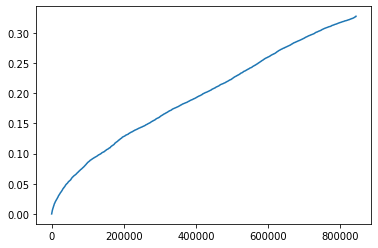

In [75]:
import matplotlib.pyplot as plt
plt.plot(td.keys(), rhos)